# Pattern Recognition, Homework 1

This is the code for the assignment of course Pattern Recognition, NYCU, in spring 2021.

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

## Load data

In [2]:
train_df = pd.read_csv('./train_data.csv')
x_train, y_train = train_df['x_train'], train_df['y_train']

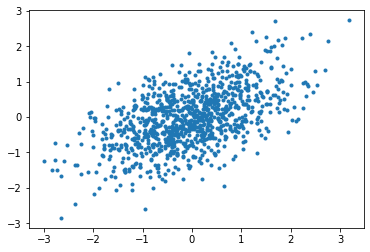

In [3]:
plt.plot(x_train, y_train, '.')

## Train regression model

This part is to train a regression model to minimize the error of the objective function of our training data.

Our model is a linear function $f:y = \beta_0 + \beta_1 x$, where $x$ is the given input and $y$ is the target value.  
The objective functions we chose are mean absolute error $L(f) = \sum_n{\left\lvert \hat{y}_n - y_n \right\rvert}$ and mean square error $L(f) = \sum_n{(\hat{y}_n - y_n)^2}$.

In [4]:
def MAELoss(target, predict):
    return np.sum(np.abs(target - predict)) / len(predict)

def MSELoss(target, predict):
    return np.sum(np.power(target - predict, 2)) / len(predict)

In [5]:
class RegDataset:
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        data = np.array(self.df.iloc[idx, 0])
        target = np.array(self.df.iloc[idx, 1])
        sample = {'data': data, 'target': target}
        return sample

In [6]:
class RegModel:
    def __init__(self):
        self.weight = np.random.normal(0, 1)
        self.bias = np.random.normal(0, 1)
        self.history = {'weight': [], 'bias': [], 'loss': []}

    def train(self, dataset, lr=0.05, epoch=100, batch_size=32, drop_last=True, criterion='MSE'):
        # Update history
        self.history['weight'].append(self.weight)
        self.history['bias'].append(self.bias)
        if criterion == 'MSE':
            self.history['loss'].append(MSELoss(dataset[:]['target'], self.predict(dataset[:]['data'])))
        elif criterion == 'MAE':
            self.history['loss'].append(MAELoss(dataset[:]['target'], self.predict(dataset[:]['data'])))

        for i in tqdm(range(epoch)):
            # Shuffle and split the dataset before each epoch
            indices = np.arange(len(dataset))
            np.random.shuffle(indices)
            batches_indices = np.array_split(indices, math.ceil(len(dataset) // batch_size))
            if drop_last:
                batches_indices = [x for x in batches_indices if 0 < x.size <= batch_size]
            # Train for each batch
            for batch_indices in batches_indices:
                self._train(dataset, batch_indices, lr, criterion)
            # Update history
            self.history['weight'].append(self.weight)
            self.history['bias'].append(self.bias)
            if criterion == 'MSE':
                self.history['loss'].append(MSELoss(dataset[:]['target'], self.predict(dataset[:]['data'])))
            elif criterion == 'MAE':
                self.history['loss'].append(MAELoss(dataset[:]['target'], self.predict(dataset[:]['data'])))

    def _train(self, dataset, indices, lr, criterion):
        data = dataset[indices]['data']
        target = dataset[indices]['target']
        predicts = self.bias + self.weight * data
        # Initialize the gradient
        w_grad = 0
        b_grad = 0
        # Gradient descent
        if criterion == 'MSE':
            w_grad += np.sum(2 * (target - predicts) * (-data)) / len(predicts)
            b_grad += np.sum(2 * (target - predicts) * (-1)) / len(predicts)
        elif criterion == 'MAE':
            indicators = np.sign(target - predicts)
            w_grad += np.sum(-indicators * data) / len(predicts)
            b_grad += np.sum(-indicators) / len(predicts)
        # Update parameters
        self.weight -= lr * w_grad
        self.bias -= lr * b_grad

    def predict(self, data):
        output = self.bias + self.weight * data
        return output

In [7]:
dataset = {'train': RegDataset('./train_data.csv'), 'test': RegDataset('./test_data.csv')}

In [8]:
regmodel_mae = RegModel()
regmodel_mae.train(dataset['train'], batch_size=len(dataset['train']), criterion='MAE')
regmodel_mse = RegModel()
regmodel_mse.train(dataset['train'], batch_size=len(dataset['train']), criterion='MSE')

100%|██████████| 100/100 [00:00<00:00, 331.11it/s]


### Learning curve

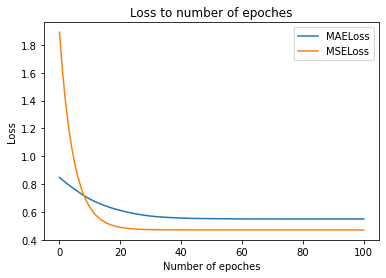

In [9]:
fig, ax = plt.subplots()
ax.plot(regmodel_mae.history['loss'], label='MAELoss')
ax.plot(regmodel_mse.history['loss'], label='MSELoss')
plt.xlabel('Number of epoches')
plt.ylabel('Loss')
plt.title('Loss to number of epoches')
plt.legend()
plt.show()

## Test

### MSE and MAE on the testing data

In [10]:
print('Mean square error:')
print('    Model with MSELoss:',
    MSELoss(dataset['test'][:]['target'], regmodel_mse.predict(dataset['test'][:]['data'])))
print('    Model with MAELoss:',
    MSELoss(dataset['test'][:]['target'], regmodel_mae.predict(dataset['test'][:]['data'])))
print('Mean absolute error:')
print('    Model with MSELoss:',
    MAELoss(dataset['test'][:]['target'], regmodel_mse.predict(dataset['test'][:]['data'])))
print('    Model with MAELoss:',
    MAELoss(dataset['test'][:]['target'], regmodel_mae.predict(dataset['test'][:]['data'])))

Mean square error:
    Model with MSELoss: 0.4909031220846389
    Model with MAELoss: 0.4944362890546527
Mean absolute error:
    Model with MSELoss: 0.5613184257592343
    Model with MAELoss: 0.5641659358447412


### Weights and intercepts

In [11]:
print('Model with MSELoss:')
print('    Weights (\\beta_1):', regmodel_mse.weight)
print('    Intercepts (\\beta_0):', regmodel_mse.bias)
print('Model with MAELoss:')
print('    Weights (\\beta_1):', regmodel_mae.weight)
print('    Intercepts (\\beta_0):', regmodel_mae.bias)

Model with MSELoss:
    Weights (\beta_1): 0.4527178624227334
    Intercepts (\beta_0): -0.0012504791113703664
Model with MAELoss:
    Weights (\beta_1): 0.4316868655198403
    Intercepts (\beta_0): -0.03666943381054179


## Difference between each gradient descent

### Batch gradient descent

Update parameters once for all traning data (once an epoch). Since we use all training data to evaluate the gradient and make a step, it would cost a lot for a step when there are enumorous training data.

### Stochastic gradient descent

Update parameters once for each training data. Although the gradient we get each time showing only the situation of the single data, we believe that we are approaching global optimal solution when considering all data. Also, this way may help reduce computational complexity.

### Mini-batch gradient descent

The mixture of **BGD** and **SGD**, lower computational complexity and not that much random noise.  
Seperate training data in several batches, each batch has part of the training data. Update parameters for each batch makes computation not that much and somehow we can update parameters base on the data distribution in the batch.


In [12]:
delta = 0.1
x = np.arange(-3, 3, delta) # bias
y = np.arange(-3, 3, delta) # weight

X, Y = np.meshgrid(x, y)
data = dataset['train'][:]['data']
target = dataset['train'][:]['target']
Z = np.sum([((target[i] - (X + Y * data[i])) ** 2) for i in range(len(data))], axis=0)

100%|██████████| 5/5 [00:00<00:00, 255.77it/s]


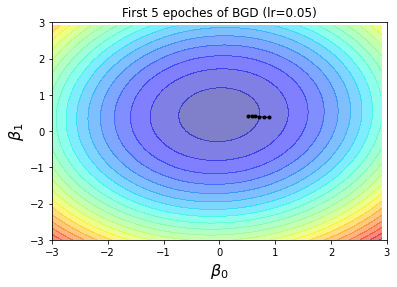

In [13]:
# Batch gradient descent
model = RegModel()
same_weight = np.random.normal(0, 1)
same_bias = np.random.normal(0, 1)
model.weight = same_weight
model.bias = same_bias
model.train(dataset['train'], epoch=5, batch_size=len(dataset['train']))

fig, ax = plt.subplots()
ax.contourf(X, Y, Z, 20, alpha=0.5, cmap=plt.get_cmap('jet'))
ax.plot(model.history['bias'], model.history['weight'], 'o-', ms=3, lw=1, color='black')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel(r'$\beta_0$', fontsize=16)
plt.ylabel(r'$\beta_1$', fontsize=16)
plt.title('First 5 epoches of BGD (lr=0.05)')
plt.show()

100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


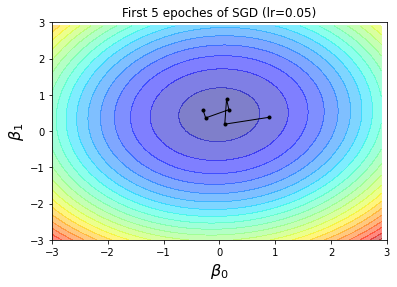

In [14]:
# Stochastic gradient descent
model = RegModel()
model.weight = same_weight
model.bias = same_bias
model.train(dataset['train'], epoch=5, batch_size=1)

fig, ax = plt.subplots()
ax.contourf(X, Y, Z, 20, alpha=0.5, cmap=plt.get_cmap('jet'))
ax.plot(model.history['bias'], model.history['weight'], 'o-', ms=3, lw=1, color='black')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel(r'$\beta_0$', fontsize=16)
plt.ylabel(r'$\beta_1$', fontsize=16)
plt.title('First 5 epoches of SGD (lr=0.05)')
plt.show()